# Heatwave: Change under climate scenarios workflow [Hazard assessment]

## Step 1: Description

**Content:**
- **1.1** Sources of the Heat-related products provided by **CDS** and **Climate adapt**
- **1.2** Heat-wave hazard estimation based on the **Euroheat** methodology.

### 1.1 Heat-Wave Hazard methodology description

#### Heatwave based on the EUROheat data [[EUROheat](https://climate-adapt.eea.europa.eu/en/metadata/tools/euroheat-online-heatwave-forecast)]

- Methodology based on the EUROheat project [[source](https://confluence.ecmwf.int/display/CKB/Heat+waves+and+cold+spells+in+Europe+derived+from+climate+projections+documentation)]:
-  **For the health-related** EU-wide definition, we rely on the results of the EUROheat project. For the summer period of June to August, heat waves were defined as days in which the maximal apparent temperature (Tappmax) exceeds the threshold (90th percentile of Tappmax for each month) and the minimum temperature (Tmin) exceeds its threshold (90th percentile of Tmin for each month) for at least two days. The apparent temperature is a measure of relative discomfort due to combined heat and high humidity, developed based on physiological studies on evaporative skin cooling. It can be calculated as a combination of air and dew point temperature.
-  **For National-related**. Each nation uses a different methodology [[source](https://confluence.ecmwf.int/display/CKB/Heat+waves+and+cold+spells+in+Europe+derived+from+climate+projections+documentation)] e.g. for Belgium, a heat wave day is a day on which both the three-day running daily minimal and maximal temperature exceeds a threshold of 18.2 °C and 29.6 °C between April and September. This condition has to be met for three consecutive days. The source of the heat wave definition is the Belgian federal public health agency.

-  **Data source** from CDS [[source](https://cds.climate.copernicus.eu/cdsapp#!/dataset/sis-heat-and-cold-spells?tab=overview)]
 
**Pros [+]**
- Less data for downloading (in comparison with the PESETAIV and XCLIM) 
- precomputed data = fast processing
- 12x12km grid for years 1986-2085 for the whole EU
- preprocessed data, no need for calculation, only the visualization of the results.
- calculated from the maximum and minimum temperatures, suitable also for the regions where the temperature can significantly drop during the nights
  
**Cons [-]**
- without the possibility of changing thresholds for temperature and days for the heat wave estimation, these thresholds are fixedly set by the EUROheat
- only yearly values
- national-related estimations are not available for each EU state. 

## Step 2: Prepare a workspace and load a libraries

### 2.1 Import packages

:::{admonition} In this notebook we will use the following Python libraries:
:class: hint dropdown
* [zipfile](https://docs.python.org/3/library/zipfile.html) - Provides tools for creating, reading, writing, and extracting ZIP files.
* [os](https://docs.python.org/3/library/os.html) - Provides functions for interacting with the operating system, such as file and directory manipulation.
* [pathlib](https://docs.python.org/3/library/pathlib.html) - Provides classes for manipulating filesystem paths in a more readable and object-oriented way.
* [cdsapi](https://cds.climate.copernicus.eu/api-how-to) - A library to request data from the datasets listed in the CDS catalogue.
* [numpy](https://numpy.org/doc/stable/) - A powerful library for numerical computations in Python, widely used for array operations and mathematical functions.
* [xarray](https://docs.xarray.dev/en/stable/) - Introduces labels in the form of dimensions, coordinates, and attributes on top of raw NumPy-like arrays for a more intuitive experience.
* [matplotlib](https://matplotlib.org/stable/) - A versatile plotting library in Python, commonly used for creating static, animated, and interactive visualizations.
* [rasterio](https://rasterio.readthedocs.io/en/latest/) - A library for reading and writing geospatial raster data.
* [plotly](https://plotly.com/) - A Python Graphing Library.
* [sklearn](https://scikit-learn.org/stable/modules/linear_model.html#linear-regression) - Module for performing linear regression, part of the scikit-learn machine learning library.
* [ipyleaflet](https://ipyleaflet.readthedocs.io/en/stable/) - Enables interactive maps in Jupyter notebooks using the Leaflet.js library.
* [ipywidgets](https://ipywidgets.readthedocs.io/en/stable/) - Provides interactive HTML widgets for Jupyter notebooks.
* [leafmap](https://leafmap.org/) - Simplifies interactive mapping with Python in Jupyter notebooks, leveraging Leaflet.js.
* [localtileserver](https://localtileserver.readthedocs.io/en/latest/) - Serves local raster tiles for visualization n Leaflet maps.


In [1]:
# Provides tools for creating, reading, writing, and extracting ZIP files.
import zipfile
# Provides functions for interacting with the operating system, such as file and directory manipulation.
import os
# Provides classes for manipulating filesystem paths in a more readable and object-oriented way.
from pathlib import Path
# Client library for the Climate Data Store (CDS) API, used for downloading climate and weather data.
import cdsapi
# Fundamental package for numerical computations in Python, especially for 2-3D array data handling.
import numpy as np
# Powerful library for handling multi-dimensional labeled arrays and datasets, often used in geosciences.
import xarray as xr
# Comprehensive library for creating static, animated, and interactive visualizations in Python.
import matplotlib.pyplot as plt
# Provides classes and functions for handling Coordinate Reference Systems (CRS) in raster data.
from rasterio.crs import CRS
# Matplotlib's procedural interface for plotting and visualization.
from pylab import pcolormesh, show, colorbar, plot, title, legend, subplot, savefig
# Another interface for Matplotlib, designed to have a similar feel to MATLAB.
from matplotlib import pyplot
# Helper function from Rasterio for visualizing raster data.
from rasterio.plot import show
# Library for reading and writing geospatial raster data.
import rasterio as rio
# Provides a high-level interface for creating interactive plots with Plotly.
import plotly.graph_objects as go
# Module for performing linear regression, part of the scikit-learn machine learning library.
from sklearn.linear_model import LinearRegression
# Enables interactive maps in Jupyter notebooks using the Leaflet.js library.
from ipyleaflet import Map, DrawControl, Marker, LayersControl
# Provides interactive HTML widgets for Jupyter notebooks.
import ipywidgets as widgets
# Simplifies interactive mapping with Python in Jupyter notebooks, leveraging Leaflet.js.
import leafmap.leafmap as leafmap
# Serves local raster tiles for visualization in Leaflet maps.
from localtileserver import get_leaflet_tile_layer, TileClient

### 2.2 Create a directory structure

In [2]:
# Define the directory for the flashflood workflow preprocess
workflow_folder = 'Heat_test2'
# Define directories for data and results within the previously defined workflow directory
data_dir = os.path.join(workflow_folder,'data')
results_dir = os.path.join(workflow_folder,'results')
# Check if the workflow directory exists, if not, create it along with subdirectories for data and results
if not os.path.exists(workflow_folder):
    os.makedirs(workflow_folder)
    os.makedirs(os.path.join(data_dir))
    os.makedirs(os.path.join(results_dir))

## Step 3: Calculation of the Heat wave occurence

Heat-wave occurence based on the Euroheat methodology.

### 3.1 Download a data from the CDS

- You can download a data from the CDS with the API - look at [[How to change your API KEY](https://cds.climate.copernicus.eu/api-how-to)] and change the KEY


In [4]:
URL = "https://cds.climate.copernicus.eu/api/v2"
KEY = "PUT-HERE-YOUR-KEY!!!" ### put here your key!!!

#### 3.1.1 Heat health-related data from Euroheat [[source](https://cds.climate.copernicus.eu/cdsapp#!/dataset/sis-heat-and-cold-spells?tab=form)]

In [ ]:
# Heat waves and cold spells in Europe derived from climate projections
c = cdsapi.Client(url=URL, key=KEY)
c.retrieve(
    'sis-heat-and-cold-spells',
    {
        'variable': 'heat_wave_days',
        'definition': 'health_related',
        'experiment': [
            'rcp4_5', 'rcp8_5',
        ],
        'ensemble_statistic': [
            'ensemble_members_average', 'ensemble_members_standard_deviation',
        ],
        'format': 'zip',
    },
   f"{data_dir}/heat_spells_health_1986_2085.zip")

In [4]:
# This code unzips the downloaded files in your working directory, so they will be ready for computing
# Define zip file's absolute path
zip_path = os.path.join(data_dir, 'heat_spells_health_1986_2085.zip')
# Extract from zip file
with zipfile.ZipFile(zip_path, 'r') as zObject:
    zObject.extractall(path=data_dir)

#### 3.1.2 Heat national-related data from Euroheat [[source](https://cds.climate.copernicus.eu/cdsapp#!/dataset/sis-heat-and-cold-spells?tab=form)]

In [ ]:
# Heat waves and cold spells in Europe derived from climate projections
c = cdsapi.Client(url=URL, key=KEY)
c.retrieve(
    'sis-heat-and-cold-spells',
    {
        'variable': 'heat_wave_days',
        'definition': 'country_related',
        'experiment': [
            'rcp4_5', 'rcp8_5',
        ],
        'ensemble_statistic': [
            'ensemble_members_average', 'ensemble_members_standard_deviation',
        ],
        'format': 'zip',
    },
   f"{data_dir}/heat_spells_country_1986_2085.zip")

In [3]:
zip_path = os.path.join(data_dir, 'heat_spells_country_1986_2085.zip')
# Extract from zip file
with zipfile.ZipFile(zip_path, 'r') as zObject:
    zObject.extractall(path=data_dir)

### 3.2 Prepare data for plotting

- In this step we prepare a data for plotting the results for the selected pixel on the EU map. 

In [3]:
# This code loads a data form data dir and sets the CRS
hwd45h = xr.open_dataset(f'{data_dir}/HWD_EU_health_rcp45_mean_v1.0.nc', decode_coords='all')
hwd85h = xr.open_dataset(f'{data_dir}/HWD_EU_health_rcp85_mean_v1.0.nc', decode_coords='all')
hwd45n = xr.open_dataset(f'{data_dir}/HWD_national_rcp45_mean_v1.0.nc', decode_coords='all')
hwd85n = xr.open_dataset(f'{data_dir}/HWD_national_rcp85_mean_v1.0.nc', decode_coords='all')
hwd45h.rio.write_crs("epsg:4326", inplace=True)
hwd85h.rio.write_crs("epsg:4326", inplace=True)
hwd45n.rio.write_crs("epsg:4326", inplace=True)
hwd85n.rio.write_crs("epsg:4326", inplace=True)

<xarray.Dataset> Size: 102MB
Dimensions:      (lat: 425, lon: 599, time: 100)
Coordinates:
    height       float64 8B ...
  * lat          (lat) float64 3kB 30.1 30.2 30.3 30.4 ... 72.2 72.3 72.4 72.5
  * lon          (lon) float64 5kB -24.9 -24.8 -24.7 -24.6 ... 34.7 34.8 34.9
  * time         (time) datetime64[ns] 800B 1986-01-01 1987-01-01 ... 2085-01-01
    spatial_ref  int32 4B 0
Data variables:
    HWD_merged   (time, lat, lon) float32 102MB ...
Attributes:
    title:          Processed EURO-CORDEX future climate data for the health ...
    conventions:    CF-1.6
    project:        Copernicus Climate Change Service Sectoral Information Sy...
    source:         Processing of bias-corrected EURO-CORDEX data by VITO
    contact:        bd_rma@vito.be
    creation_date:  Thu May  9 14:08:15 2019
    institution:    VITO (https://vito.be/en)
    history:        Mon Jul 15 13:48:58 2019: ncatted -O -a units,HWD_merged,...
    NCO:            netCDF Operators version 4.7.5 (Homepage = http://nco.sf....

In [4]:
# This code selects a variable for plotting
hwd45h=hwd45h['HWD_EU_health']
hwd85h=hwd85h['HWD_EU_health']
hwd45n=hwd45n['HWD_merged']
hwd85n=hwd85n['HWD_merged']

In [5]:
hwd45health= hwd45h.mean(dim='time', skipna=True, keep_attrs=True)
hwd45health.rio.to_raster(raster_path=f'{data_dir}/hwd45_health_mean.tif')
hwd45h.rio.to_raster(raster_path=f'{data_dir}/hwd45_health.tif')
#
hwd85health= hwd85h.mean(dim='time', skipna=True, keep_attrs=True)
hwd85health.rio.to_raster(raster_path=f'{data_dir}/hwd85_health_mean.tif')
hwd85h.rio.to_raster(raster_path=f'{data_dir}/hwd85_health.tif')
#
hwd45national= hwd45n.mean(dim='time', skipna=True, keep_attrs=True)
hwd45national.rio.to_raster(raster_path=f'{data_dir}/hwd45_national_mean.tif')
hwd45n.rio.to_raster(raster_path=f'{data_dir}/hwd45_national.tif')
#
hwd85national= hwd85n.mean(dim='time', skipna=True, keep_attrs=True)
hwd85national.rio.to_raster(raster_path=f'{data_dir}/hwd85_national_mean.tif')
hwd85n.rio.to_raster(raster_path=f'{data_dir}/hwd85_national.tif')

### 3.3 Select a pixel for plotting

In [4]:
# This code plots the map where we need to select the point for the plot of the graphs for computed indices
# First, create a tile server from local raster file
client1 = TileClient(f'{data_dir}/hwd45_health_mean.tif')
client2 = TileClient(f'{data_dir}/hwd45_national_mean.tif')
client3 = TileClient(f'{data_dir}/hwd85_health_mean.tif')
client4 = TileClient(f'{data_dir}/hwd85_national_mean.tif')
# Create ipyleaflet tile layer from that server
t1 = get_leaflet_tile_layer(client1, cmap='Reds', opacity=0.5, nodata=0, name='Heat-wave health rcp 4.5')
t2 = get_leaflet_tile_layer(client2, cmap='Reds', opacity=0.5, nodata=0, name='Heat-wave national rcp 4.5')
t3 = get_leaflet_tile_layer(client3, cmap='Reds', opacity=0.5, nodata=0, name='Heat-wave health rcp 8.5')
t4 = get_leaflet_tile_layer(client4, cmap='Reds', opacity=0.5, nodata=0, name='Heat-wave national rcp 8.5')
#m = Map(center=client1.center(), zoom=client1.default_zoom)
m = Map(center=client1.center(), zoom=client1.default_zoom)
m = Map(center=client2.center(), zoom=client2.default_zoom)
m = Map(center=client3.center(), zoom=client1.default_zoom)
m = Map(center=client4.center(), zoom=client2.default_zoom)
m.add(t1)
m.add(t2)
m.add(t3)
m.add(t4)
control = LayersControl(position='topright')
m.add_control(control)
# Create lists to store point coordinates
point_lon_list = []
point_lat_list = []
# Create a DrawControl with point drawing enabled
draw_control = DrawControl(marker={'shapeOptions': {'color': '#FF0000'}})
# Add the DrawControl to the map
m.add_control(draw_control)
# Create a text widget to display coordinates
coord_output = widgets.Text(placeholder='Coordinates will appear here', disabled=True)
# Define a function to handle draw events
def handle_draw(self, action, geo_json):
    if action == 'created':
        if geo_json['geometry']['type'] == 'Point':
            # Extract coordinates of the point
            lon, lat = geo_json['geometry']['coordinates']
            # Update text widget with coordinates
            coord_output.value = f'Coordinates: ({lon:.2f}, {lat:.2f})'
            # Append coordinates to lists
            point_lon_list.append(lon)
            point_lat_list.append(lat)
            # Create and add a marker to the map
            marker = Marker(location=(lat, lon))
            #m.add_layer(marker)
# Attach the event handler to the DrawControl
draw_control.on_draw(handle_draw)
# Arrange the map and text widget vertically
display(widgets.VBox([m, coord_output]))


- **Select the map with the top right panel.**
- **Zoom with [+]/[-] to your area**
- **Select a pixel for plotting the values, with "Draw a marker" from the left panel**
- On the map above you can see the mean values of the heat-wave occurrence for the years 1986-2085 for the **rcp 4.5 and 8.5** based on the **health and national related** data.
- The total number of heat occurrences for this map is not important, important is to see which areas can be most influenced by the heat. 

In [10]:
# This code extracts the data values for the selected pixel
hwd45h = xr.open_dataset(f'{data_dir}/hwd45_health.tif')
hwd85h = xr.open_dataset(f'{data_dir}/hwd85_health.tif')
hwd45n = xr.open_dataset(f'{data_dir}/hwd45_national.tif')
hwd85n = xr.open_dataset(f'{data_dir}/hwd85_national.tif')
lat = point_lat_list[0] 
lon = point_lon_list[0]
extracted_data1 = hwd45h.sel(y=lat, x=lon, method='nearest')
extracted_data2 = hwd85h.sel(y=lat, x=lon, method='nearest')
extracted_data3 = hwd45n.sel(y=lat, x=lon, method='nearest')
extracted_data4 = hwd85n.sel(y=lat, x=lon, method='nearest')
d1=extracted_data1['band_data']
hwd45h = d1.values.tolist()
d2=extracted_data2['band_data']
hwd85h = d2.values.tolist()
d3=extracted_data3['band_data']
hwd45n = d3.values.tolist()
d4=extracted_data4['band_data']
hwd85n = d4.values.tolist()

### 3.4 Plots results for EuroHeat for selected pixel

#### 3.4.1 Plots results for health-related data

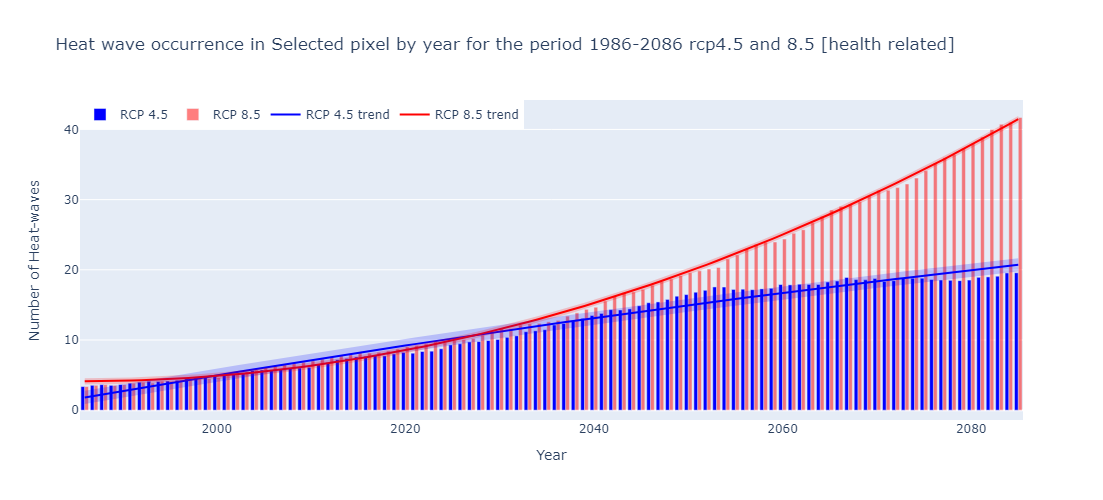

In [12]:
b = hwd45h
t = hwd85h
# Define years
year = list(range(1986, 2086))
# Fit polynomial regression curves (degree 2 for simplicity)
b_poly = np.polyfit(np.arange(len(b)), b, 2)
t_poly = np.polyfit(np.arange(len(t)), t, 2)
# Calculate polynomial values
b_poly_values = np.polyval(b_poly, np.arange(len(b)))
t_poly_values = np.polyval(t_poly, np.arange(len(t)))
# Calculate the residuals and standard error for b
b_residuals = b - b_poly_values
b_std_error = np.std(b_residuals)
# Calculate the residuals and standard error for t
t_residuals = t - t_poly_values
t_std_error = np.std(t_residuals)
# Create figure
fig = go.Figure()
# Add bar trace for 'b'
fig.add_trace(go.Bar(x=year, y=b, name='RCP 4.5', marker_color='blue'))
# Add bar trace for 't'
fig.add_trace(go.Bar(x=year, y=t, name='RCP 8.5', opacity=0.5, marker_color='red'))
# Add polynomial regression curve for 'b'
fig.add_trace(go.Scatter(x=year, y=b_poly_values, mode='lines', name='RCP 4.5 trend', line=dict(color='blue')))
# Add polynomial regression curve for 't'
fig.add_trace(go.Scatter(x=year, y=t_poly_values, mode='lines', name='RCP 8.5 trend', line=dict(color='red')))
# Add standard error band for 'b'
fig.add_trace(go.Scatter(
    x=year + year[::-1],
    y=list(b_poly_values + b_std_error) + list((b_poly_values - b_std_error)[::-1]),
    fill='toself',
    fillcolor='rgba(0,0,255,0.2)',
    line=dict(color='rgba(255,255,255,0)'),
    hoverinfo="skip",
    showlegend=False
))
# Add standard error band for 't'
fig.add_trace(go.Scatter(
    x=year + year[::-1],
    y=list(t_poly_values + t_std_error) + list((t_poly_values - t_std_error)[::-1]),
    fill='toself',
    fillcolor='rgba(255,0,0,0.2)',
    line=dict(color='rgba(255,255,255,0)'),
    hoverinfo="skip",
    showlegend=False
))
# Update layout
fig.update_layout(
    title='Heatwave occurrence in Selected pixel by year for the period 1986-2086 rcp4.5 and 8.5 [health-related]',
    xaxis_title='Year',
    yaxis_title='Number of heatwaves',
    legend=dict(x=0, y=1, traceorder='normal', orientation='h'),
    width=1100,
    height=500
)
fig.show()

- the graph above plots the heatwave occurrence for selected pixel for 1986-2086 for rcp 4.5 and 8.5
- these results are based on the **heatlh-related** thresholds based on the EuroHEAT project [[source](https://confluence.ecmwf.int/display/CKB/Heat+waves+and+cold+spells+in+Europe+derived+from+climate+projections+documentation)]
- the regression curve is plotted with the standard error around the line [[source](https://blog.minitab.com/en/adventures-in-statistics-2/regression-analysis-how-to-interpret-s-the-standard-error-of-the-regression)]

#### 3.4.2 Plots results for national-related data

- **The national related data are available only for the few states in EU please see the map in 3.3!!!**

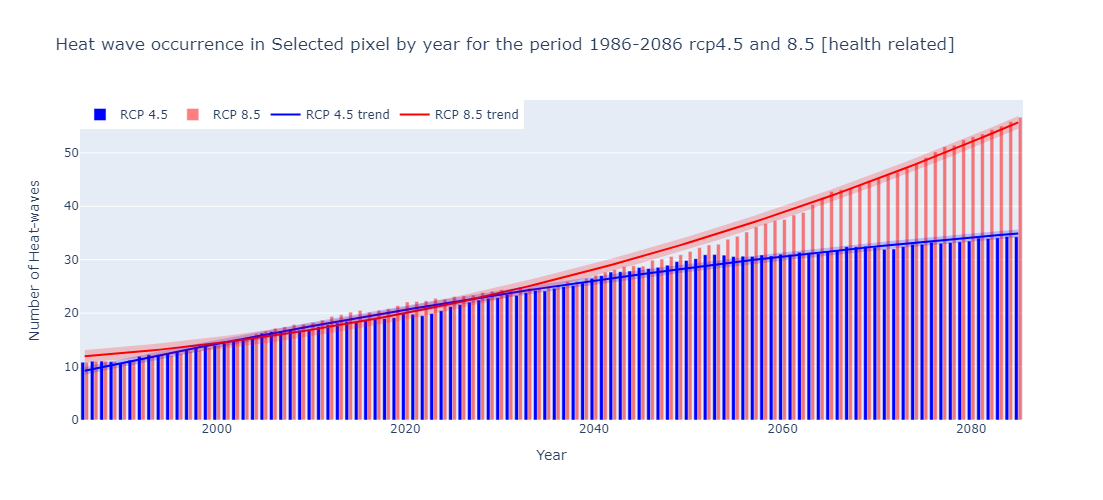

In [13]:
b = hwd45n
t = hwd85n
# Define years
year = list(range(1986, 2086))
# Fit polynomial regression curves (degree 2 for simplicity)
b_poly = np.polyfit(np.arange(len(b)), b, 2)
t_poly = np.polyfit(np.arange(len(t)), t, 2)
# Calculate polynomial values
b_poly_values = np.polyval(b_poly, np.arange(len(b)))
t_poly_values = np.polyval(t_poly, np.arange(len(t)))
# Calculate the residuals and standard error for b
b_residuals = b - b_poly_values
b_std_error = np.std(b_residuals)
# Calculate the residuals and standard error for t
t_residuals = t - t_poly_values
t_std_error = np.std(t_residuals)
# Create figure
fig = go.Figure()
# Add bar trace for 'b'
fig.add_trace(go.Bar(x=year, y=b, name='RCP 4.5', marker_color='blue'))
# Add bar trace for 't'
fig.add_trace(go.Bar(x=year, y=t, name='RCP 8.5', opacity=0.5, marker_color='red'))
# Add polynomial regression curve for 'b'
fig.add_trace(go.Scatter(x=year, y=b_poly_values, mode='lines', name='RCP 4.5 trend', line=dict(color='blue')))
# Add polynomial regression curve for 't'
fig.add_trace(go.Scatter(x=year, y=t_poly_values, mode='lines', name='RCP 8.5 trend', line=dict(color='red')))
# Add standard error band for 'b'
fig.add_trace(go.Scatter(
    x=year + year[::-1],
    y=list(b_poly_values + b_std_error) + list((b_poly_values - b_std_error)[::-1]),
    fill='toself',
    fillcolor='rgba(0,0,255,0.2)',
    line=dict(color='rgba(255,255,255,0)'),
    hoverinfo="skip",
    showlegend=False
))
# Add standard error band for 't'
fig.add_trace(go.Scatter(
    x=year + year[::-1],
    y=list(t_poly_values + t_std_error) + list((t_poly_values - t_std_error)[::-1]),
    fill='toself',
    fillcolor='rgba(255,0,0,0.2)',
    line=dict(color='rgba(255,255,255,0)'),
    hoverinfo="skip",
    showlegend=False
))
# Update layout
fig.update_layout(
    title='Heatwave occurrence in selected pixel by year for the period 1986-2086 rcp4.5 and 8.5 [national-related]',
    xaxis_title='Year',
    yaxis_title='Number of heatwaves',
    legend=dict(x=0, y=1, traceorder='normal', orientation='h'),
    width=1100,
    height=500
)
fig.show()

- **These data are provided only for the selected countries in the EU** list of selected countries (Belgium, Hungary, Italy, United Kingdom, Sweden, Lithuania, Latvia, Estonia, Finland)
- the graph above plots the heatwave occurrence for selected pixel for 1986-2086 for rcp 4.5 and 8.5
- these results are based on the **national-related** thresholds based on the EuroHEAT project [[source](https://confluence.ecmwf.int/display/CKB/Heat+waves+and+cold+spells+in+Europe+derived+from+climate+projections+documentation)]
- the regression cure is plotted with the standard error around the line [[source](https://blog.minitab.com/en/adventures-in-statistics-2/regression-analysis-how-to-interpret-s-the-standard-error-of-the-regression)]

## Step 4: Conclusion for the Euroheat results

- This notebook provides the results based on the precomputed data from the CDS. You can also see the results directly on the CDS [[source](https://cds.climate.copernicus.eu/cdsapp#!/software/app-health-heat-waves-projections?tab=app)] for the NUTS3 administrative regions resolution. However, this notebook provides a way to extract results for the selected pixel (12.5 x 12.5km) over the EU. 
- The results of the Euroheat methodology show the heat-wave occurrence for each year. We can plot the results based on the health-related thresholds or national-related thresholds (see the methodologies description Step: 1).
- The health-related data are available for the whole EU, but the national-related data are available only for a few states (see the plot in 3.3)

## References 

- Copernicus Climate Data Store, Heat wave days for European countries derived from climate projections (2021), https://cds.climate.copernicus.eu/cdsapp#!/software/app-health-heat-waves-projections?tab=app [2024-06-17]. 

- Copernicus Climate Data Store, Heat wave days for Europe derived from ERA5 reanalysis (2021), https://cds.climate.copernicus.eu/cdsapp#!/software/app-health-heat-waves-current-climate?tab=app [2024-06-17].

- Copernicus Climate Data Store, Heat wave days and heat-related mortality for nine European cities (2021), https://cds.climate.copernicus.eu/cdsapp#!/software/app-health-urban-heat-related-mortality-projections?tab=app [2024-06-17].

- Copernicus Climate Data Store, Heat waves and cold spells in Europe derived from climate projections (2019), https://cds.climate.copernicus.eu/cdsapp#!/dataset/sis-heat-and-cold-spells?tab=overview [2024-06-17].

- Climate adapt, Apparent temperature heat-wave days (2021), https://climate-adapt.eea.europa.eu/en/metadata/indicators/apparent-temperature-heatwave-days [2024-06-17].

- Hooyberghs, H., Berckmans, J., Lefebre, F., De Ridder, K. (2019): Heat waves and cold spells in Europe derived from climate projections. Copernicus Climate Change Service (C3S) Climate Data Store (CDS). DOI: 10.24381/cds.9e7ca677 (Accessed on 06-17-2024)

- Climate adapt, Tropical nights (2021), https://climate-adapt.eea.europa.eu/en/observatory/++aq++metadata/indicators/tropical-nights/ [2024-06-17].

- Climate adapt, High UTCI Days (2021), https://climate-adapt.eea.europa.eu/en/metadata/indicators/high-utci-days [2024-06-17].

- Climate adapt, EuroHEATonline heat-wave forecast (2007), https://climate-adapt.eea.europa.eu/en/metadata/tools/euroheat-online-heatwave-forecast [2024-06-17]

## Authors 

- Martin Kuban, KAJO services (martin.kuban@kajoservices.com)
- Milan Kalas, KAJO services (milan.kalas@kajoservices.com)